# Fixing a Corrupted Model
```In this exercise you will experience with "debugging" a model. You will analyze the datasets and the differences between them and the problems in the training process of the model.```

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = 12,7

```Here you will explore a trained model and see where, and more interestingly, why, it fails.```

- ```Completion Rate (CR) is the the percentage of orders that were completed successfully. You have a model that predicts this measurement in Kazan, a city in Russia```
- ```Attached to this notebook are two files: `train.csv` and `test.csv` ```
- ```A model to predict CR (`cr_guas`) was trained on `train.csv` (`DataAnalyst-Model.ipynb`) and saved into `model.pkl` ```
- ```Your task is to analyze the model results and find out if there are any issues with it```
- ```Please answer the questions below```
- ```Provide proofs in the form of statistics and plots```
- ```Write your own conclusion about the results and your suggestions for a solution```
- ```There are at least two major problems, and some other minor problems```

# Load Data

In [2]:
df_train = pd.read_csv('resources/train.csv', encoding='utf-8')
df_test = pd.read_csv('resources/test.csv', encoding='utf-8')

In [3]:
df_train.sample(5)

,sample_t,area,weekday,weekdaycat,hour,hourcat,cos604800,sin604800,cr_weight,cr_gaus,cr_mean
26501,1521468000,Kazan Спартаковская улица,0.583333,NaN,14.000000,14,-0.563320,-0.826239,4.123492,0.895817,0.620895
9232,1521274500,Kazan Парк Хаус,5.343750,NaN,8.250000,8,-0.508075,0.861313,31.697170,0.847643,0.718425
116200,1521690300,Kazan улица Оренбургский тракт,3.156250,3.0,3.750000,3,0.990181,0.139790,7.249848,0.531852,0.400169
71412,1521191700,Kazan улица Патриса Лумумбы,4.385417,NaN,9.250000,9,0.321439,0.946930,11.825706,0.721723,0.447960
77701,1522196700,Kazan Парк Хаус,2.017361,0.0,0.416667,0,0.635597,-0.772021,1.067103,0.936635,0.832933


# Load model

In [3]:
from lightgbm import LGBMRegressor

In [5]:
# lgb = joblib.load('resources/model.pkl')
import pickle

lgb = pickle.load(open('resources/model.pkl','rb'), encoding="latin1")

In [6]:
features = lgb.booster_.feature_name()
features

['area',
 'weekday',
 'weekdaycat',
 'hour',
 'hourcat',
 'cos604800',
 'sin604800',
 'cr_mean']

In [7]:
df_train['area'] = df_train['area'].astype('category')
df_train['weekdaycat'] = df_train['weekdaycat'].astype('category')
df_train['hourcat'] = df_train['hourcat'].astype('category')

df_test['area'] = df_test['area'].astype(df_train['area'].dtype)
df_test['weekdaycat'] = df_test['weekdaycat'].astype(df_train['weekdaycat'].dtype)
df_test['hourcat'] = df_test['hourcat'].astype(df_train['hourcat'].dtype)

In [8]:
df_train['cr_pred'] = lgb.predict(df_train[features])
df_test['cr_pred'] = lgb.predict(df_test[features])

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("train MSE", mean_squared_error(df_train['cr_gaus'], df_train['cr_pred']))
print("test MSE", mean_squared_error(df_test['cr_gaus'], df_test['cr_pred']))

print("train MAE", mean_absolute_error(df_train['cr_gaus'], df_train['cr_pred']))
print("test MAE", mean_absolute_error(df_test['cr_gaus'], df_test['cr_pred']))

train MSE 0.023302482148964982
test MSE 0.15525000388861024
train MAE 0.1124869428765903
test MAE 0.30727150107998624


In [10]:
print("train shape", df_train.shape, "test shape", df_test.shape)

for feature in features:
    print("for feature", feature, "nb of nan in train", df_train[feature].isna().sum(), 
          "in test", df_test[feature].isna().sum())
    

train shape (121068, 12) test shape (39492, 12)
for feature area nb of nan in train 0 in test 0
for feature weekday nb of nan in train 0 in test 0
for feature weekdaycat nb of nan in train 88914 in test 39492
for feature hour nb of nan in train 0 in test 0
for feature hourcat nb of nan in train 0 in test 0
for feature cos604800 nb of nan in train 0 in test 0
for feature sin604800 nb of nan in train 0 in test 0
for feature cr_mean nb of nan in train 0 in test 0


In [11]:
from sklearn.metrics import mutual_info_score
from math import log, e

def SU(x_i, x_j):
    def entropy(labels, base=None):
        """ Computes entropy of label distribution. """
        n_labels = len(labels)
        if n_labels <= 1:
            return 0
        value, counts = np.unique(labels, return_counts=True)
        probs = counts / n_labels
        n_classes = np.count_nonzero(probs)
        if n_classes <= 1:
            return 0
        ent = 0.
        # Compute entropy
        base = e if base is None else base
        for i in probs:
            ent -= i * log(i, base)
        return ent

    return 2 * (mutual_info_score(x_i, x_j) / (entropy(x_i) + entropy(x_j)))

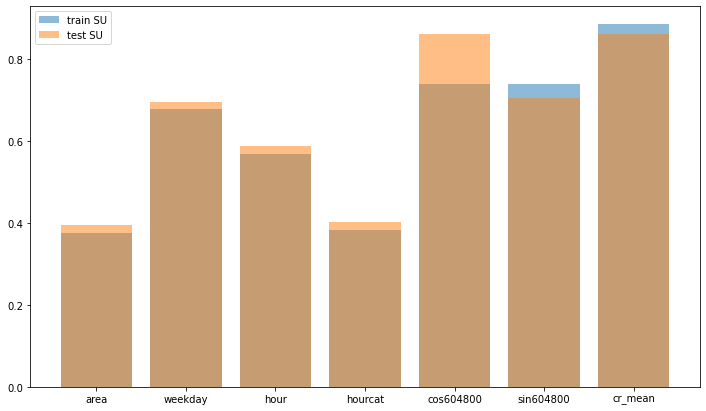

In [12]:
relevant_features, train_SU, test_SU = [], [], []
for feature in features:
    if feature == 'weekdaycat':
        continue
    relevant_features.append(feature)
    train_SU.append(SU(df_train[feature], df_train['cr_gaus']))
    test_SU.append(SU(df_test[feature], df_test['cr_gaus']))

p1 = plt.bar(relevant_features, train_SU, label="train SU", alpha=0.5)
p2 = plt.bar(relevant_features, test_SU, label="test SU", alpha=0.5)
plt.legend()
plt.show()

In [13]:
for feature in lgb.booster_.feature_name():
    print(feature, df_train[feature].dtype, df_test[feature].dtype)

area category category
weekday float64 float64
weekdaycat category category
hour float64 float64
hourcat category category
cos604800 float64 float64
sin604800 float64 float64
cr_mean float64 float64


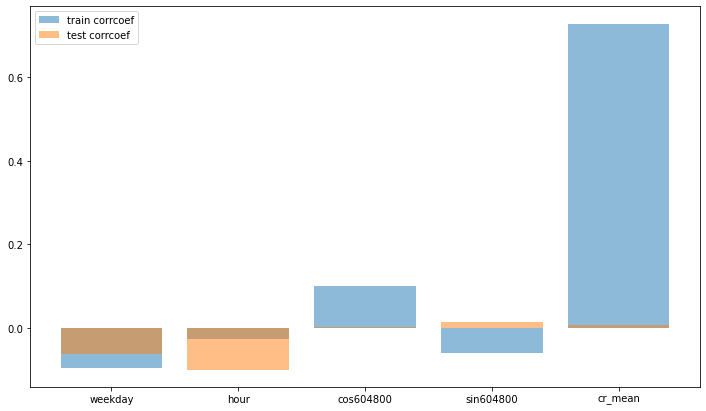

In [15]:
features_to_print, train_SU, test_SU = [], [], []
for feature in lgb.booster_.feature_name():
    if feature == 'weekdaycat':
        continue
    if df_train[feature].dtype.name == 'category':
        continue
    features_to_print.append(feature)
    train_SU.append(np.corrcoef(df_train[feature], df_train['cr_gaus'])[0][1])
    test_SU.append(np.corrcoef(df_test[feature], df_test['cr_gaus'])[0][1])

p1 = plt.bar(features_to_print, train_SU, label="train corrcoef", alpha=0.5)
p2 = plt.bar(features_to_print, test_SU, label="test corrcoef", alpha=0.5)
plt.legend()
plt.show()

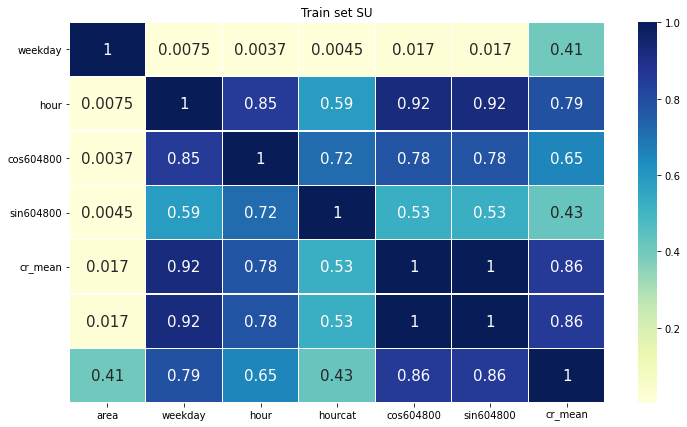

In [21]:
features_SU = lgb.booster_.feature_name()
features_SU.remove('weekdaycat')

SU_values = np.zeros(shape=(len(features_SU), len(features_SU)), dtype=float)

for ii, feature_i in enumerate(features_SU):
    for jj, feature_j in enumerate(features_SU):
        SU_values[ii, jj] = SU(df_train[feature_i], df_train[feature_j])

fontsize = 15
plt.title("Train set SU")
sns.heatmap(SU_values, annot=True, linewidths=.3, cmap="YlGnBu",
            yticklabels=relevant_features, xticklabels=features_SU, annot_kws={"fontsize": fontsize})
plt.show()

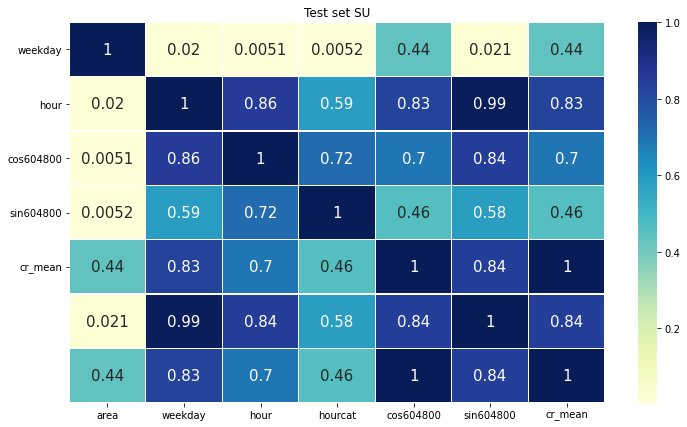

In [22]:
SU_values = np.zeros(shape=(len(features_SU), len(features_SU)), dtype=float)

for ii, feature_i in enumerate(features_SU):
    for jj, feature_j in enumerate(features_SU):
        SU_values[ii, jj] = SU(df_test[feature_i], df_test[feature_j])

fontsize = 15
plt.title("Test set SU")
sns.heatmap(SU_values, annot=True, linewidths=.3, cmap="YlGnBu",
            yticklabels=relevant_features, xticklabels=features_SU, annot_kws={"fontsize": fontsize})
plt.show()

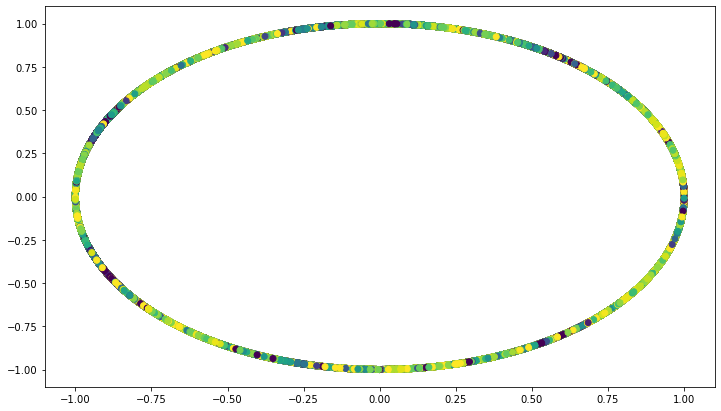

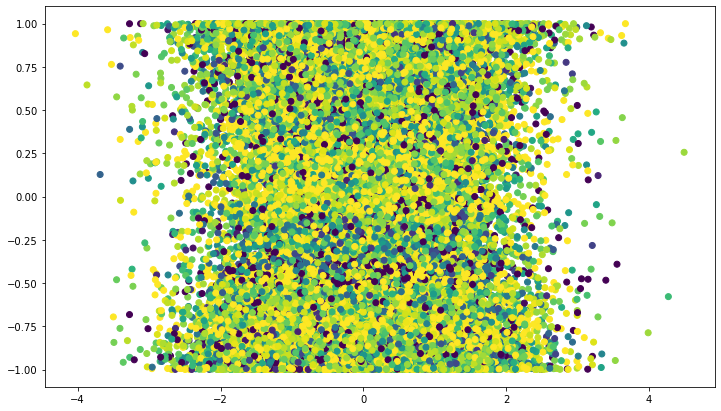

In [36]:
plt.scatter(df_train['cos604800'], df_train['sin604800'],c=df_train['cr_gaus'])
plt.show()

plt.scatter(df_test['cos604800'], df_test['sin604800'],c=df_test['cr_gaus'])
plt.show()

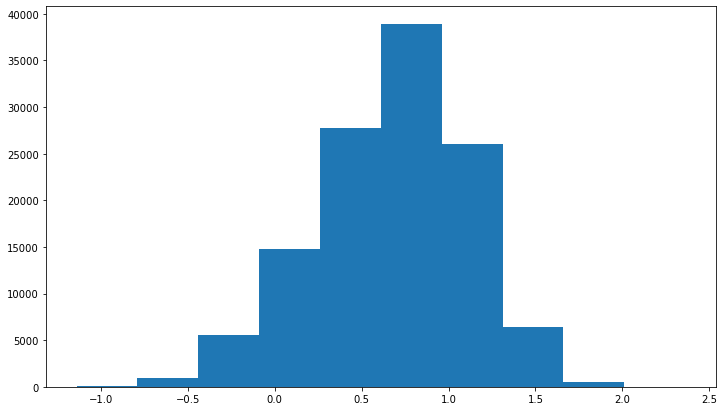

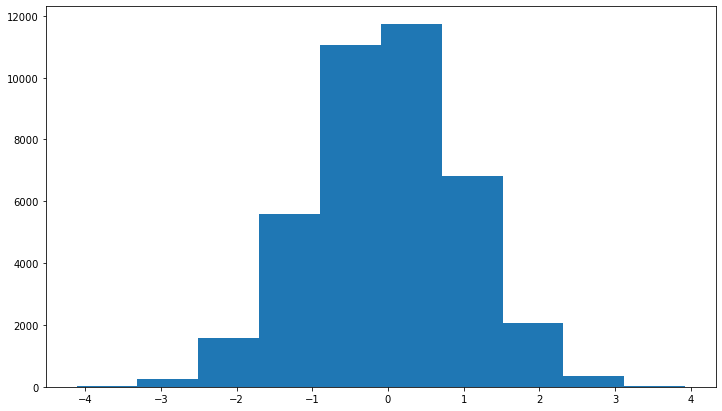

In [43]:
plt.hist(df_train['cr_mean'])
plt.show()

plt.hist(df_test['cr_mean'])
plt.show()

In [44]:
def FCBF(X, C, delta=0.05):
    """
    https://www.aaai.org/Papers/ICML/2003/ICML03-111.pdf
    """
    features_name = X.columns
    
    X = X.values
    C = C.values

    N = X.shape[1]
    S_list = []
    for i in range(N):
        SU_i_c = SU(X[:, i], C)

        if SU_i_c > delta:
            S_list.append((i, SU_i_c, features_name[i]))
    
    S_list = sorted(S_list, key=lambda x: x[1], reverse=True)
    S_list.append(("end", ""))
    S_list.append(("end", ""))
 
    idx_p = 0
    Fp = S_list[idx_p]
    
    while Fp[0] != "end":
        idx_q = idx_p + 1
        Fq = S_list[idx_q]
        while Fq[0] != "end":
            if SU(X[:, Fp[0]], X[:, Fq[0]]) > Fq[1]:
                S_list.remove(Fq)
                Fq = S_list[idx_q]
            else:
                idx_q += 1
                Fq = S_list[idx_q]
        Fp = S_list[idx_p]
        idx_p += 1
    
    S_list.remove(("end", ""))
    S_list.remove(("end", ""))
    return S_list

In [47]:
selected_features = FCBF(df_train.drop(columns=['cr_gaus', 'weekdaycat', 'cr_weight']), df_train['cr_gaus'])
print(selected_features)

[(7, 0.8839562449834455, 'cr_mean')]


In [52]:
selected_features = FCBF(df_train.drop(columns=['cr_gaus', 'weekdaycat', 'cr_weight', 'cr_mean', 'cr_pred']), 
                         df_train['cr_gaus'])
print(selected_features)

[(0, 0.7382379044467885, 'sample_t'), (1, 0.37431680360663844, 'area')]


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_model(features):
    lgb = LGBMRegressor(n_estimators=10**4, max_depth=9, num_leaves=20,colsample_bytree=0.7, subsample=0.9, learning_rate=0.5)
    lgb.fit(df_train[features], df_train['cr_gaus'], verbose=100)

    new_predict_train = lgb.predict(df_train[features])
    new_predict_test = lgb.predict(df_test[features])

    print("train MSE", mean_squared_error(df_train['cr_gaus'], new_predict_train))
    print("test MSE", mean_squared_error(df_test['cr_gaus'],new_predict_test))

    print("train MAE", mean_absolute_error(df_train['cr_gaus'], new_predict_train))
    print("test MAE", mean_absolute_error(df_test['cr_gaus'], new_predict_test))

In [27]:
features = ['area', 'weekday', 'hour', 'hourcat', 'sin604800']
train_model(features)

train MSE 0.036769717482559076
test MSE 0.08186617001233594
train MAE 0.13552815635674098
test MAE 0.2011632603120702


In [28]:
features = ['cr_mean']
train_model(features)

train MSE 0.04260201273250347
test MSE 0.3306195488614214
train MAE 0.1585658817700558
test MAE 0.4798214445005084


In [29]:
features = ['sample_t', 'area']
train_model(features)

train MSE 0.08540295880139881
test MSE 0.18393787618774565
train MAE 0.2308483663310484
test MAE 0.3932780847347833


In [8]:
features = ['weekday', 'hour', 'hourcat', 'sin604800', 'sample_t']
train_model(features)

train MSE 0.08101017528518288
test MSE 0.10293451067437084
train MAE 0.22269436725785666
test MAE 0.23014458870668011


# Results

```Please analyze and compare the MAE of the predictions```

1. ```Is there any difference between train\test? Why?```
2. ```Is there any difference between areas? If so, why?```
3. ```The PM still thinks there is a problem with our prediction... I can't find any problem, Can you? Find as many as you can!```

**Don't forget your plots**